### Credit Risk Analytics - Machine Learning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.formula.api as smf

<Figure size 720x540 with 0 Axes>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

In [3]:
# Load the data
bankloans = pd.read_csv( 'bankloans.csv' )

In [4]:
bankloans.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [5]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [6]:
bankloans_existing = bankloans[bankloans.default.isnull()==0]
bankloans_new = bankloans[bankloans.default.isnull()==1]

In [7]:
#Missing vlaue treatment
def missings_treat(x):
    x = x.fillna(x.median())
    return x

#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99), lower =x.quantile(0.01) )
    return x

bankloans_existing=bankloans_existing.apply(lambda x: missings_treat(x))
bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))

In [8]:
gini_df = pd.DataFrame()
for col in bankloans_existing.columns.difference(['default']):
    model = smf.logit('default~'+str(col), data=bankloans_existing).fit()
    gini = 2*metrics.roc_auc_score(bankloans_existing.default, model.predict(bankloans_existing))-1
    temp = pd.DataFrame([col, gini]).T
    gini_df = pd.concat([gini_df, temp], axis=0)

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [9]:
gini_df.columns= ['Feature', 'SomerceD']
gini_df.sort_values(by='SomerceD', ascending=False, inplace=True)

In [10]:
gini_df

,Feature,SomerceD
0,debtinc,0.470506
0,employ,0.409138
0,creddebt,0.272378
0,address,0.222384
0,age,0.206329
0,income,0.200273
0,othdebt,0.173806
0,ed,0.148302


In [11]:
#RFE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
X = bankloans_existing[bankloans_existing.columns.difference(['default'])]
y = bankloans_existing[['default']]

rfe = RFE(RandomForestClassifier(), 5)
rfe = rfe.fit(X, y)

X.columns[rfe.get_support()]

C:\Users\om\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\om\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
C:\Users\om\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y)
C:\Users\om\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:241: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Index(['creddebt', 'debtinc', 'employ', 'income', 'othdebt'], dtype='object')

In [12]:
Final_list = [
#'age',
'employ',
'address',
#'income',
'debtinc',
'creddebt',
'othdebt'
]

In [13]:
X_new = X[Final_list]
### VIF Calculation for variables
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns

In [14]:
vif.sort_values(by='VIF_Factor',ascending=False)

,VIF_Factor,features
4,4.436528,othdebt
2,3.624147,debtinc
3,3.269440,creddebt
0,3.073768,employ
1,2.481654,address


In [15]:
data_final = pd.concat([X_new, y], axis=1)

In [16]:
data_final

,employ,address,debtinc,creddebt,othdebt,default
0,17.0,12.0,9.3,9.891428,5.008608,1.0
1,10.0,6.0,17.3,1.362202,4.000798,0.0
2,15.0,14.0,5.5,0.856075,2.168925,0.0
3,15.0,14.0,2.9,2.658720,0.821280,0.0
4,2.0,0.0,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...
695,6.0,15.0,4.6,0.262062,0.979938,1.0
696,6.0,4.0,11.5,0.369495,2.045505,0.0
697,15.0,3.0,7.6,0.491264,1.940736,0.0
698,19.0,22.0,8.4,2.302608,4.165392,0.0


In [17]:
#split the data into train & test
train, test = train_test_split(data_final, test_size=0.3, random_state=123)

In [18]:
formula = 'default~address+creddebt+debtinc+employ'

In [19]:
model = smf.logit(formula, data=train).fit()

Optimization terminated successfully.
         Current function value: 0.400953
         Iterations 7


In [20]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                  490
Model:                          Logit   Df Residuals:                      485
Method:                           MLE   Df Model:                            4
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:                  0.3118
Time:                        08:26:14   Log-Likelihood:                -196.47
converged:                       True   LL-Null:                       -285.50
Covariance Type:            nonrobust   LLR p-value:                 1.944e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8974      0.299     -3.000      0.003      -1.484      -0.311
address       -0.0724      0.024     -2.995      0.003      -0.120      -0.025
creddebt       0.6506      0.106      6.146      0.0

In [21]:
logreg = model

In [22]:
#Metrics based on the probability - AUC, Gini
train['prob'] = model.predict(train)
test['prob'] = model.predict(test)

C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
train_auc = metrics.roc_auc_score(train.default, train.prob)
train_auc

0.8562510580667005

In [24]:
test_auc = metrics.roc_auc_score(test.default, test.prob)
test_auc

0.8403009002343076

In [25]:
#Calculating Gini (somerceD) for train & Test
train_gini = 2*metrics.roc_auc_score(train.default, train.prob)-1
train_gini

0.7125021161334011

In [26]:
test_gini = 2*metrics.roc_auc_score(test.default, test.prob)-1
test_gini

0.6806018004686152

In [27]:
temp = train
roc_df = pd.DataFrame()
for cut_off in np.linspace(0,1):
    temp['y_pred'] = np.where(train.prob>cut_off, 1, 0)
    temp['TP'] = np.where(((train.default ==1) & (train.y_pred==1)), 1,0)
    temp['TN'] = np.where(((train.default ==0) & (train.y_pred==0)), 1,0)
    temp['FP'] = np.where(((train.default ==0) & (train.y_pred==1)), 1,0)
    temp['FN'] = np.where(((train.default ==1) & (train.y_pred==0)), 1,0)
    sensitivity = temp.TP.sum()/(temp.TP.sum()+temp.FN.sum())
    specificity = temp.TN.sum()/(temp.TN.sum()+temp.FP.sum())
    accuracy = (temp.TN.sum()+temp.TP.sum())/(temp.y_pred.count())
    temp_df = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    temp_df.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_df = pd.concat([roc_df, temp_df], axis=0)

C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [28]:
roc_df['total'] = roc_df.sensitivity + roc_df.specificity

In [29]:
roc_df.sort_values(by = 'total', ascending=False).head(1)

,cutoff,sensitivity,specificity,accuracy,total
0,0.265306,0.795455,0.756983,0.767347,1.552438


In [30]:
#From above step, the cut-off is: 0.265306
train['default_pred'] = np.where(train.prob>0.265306, 1, 0)
test['default_pred'] = np.where(test.prob>0.265306, 1, 0)

C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
#Good ness of fit metrics based on categorical predicted output for train & test

print(metrics.classification_report(train.default, train.default_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.76      0.83       358
         1.0       0.55      0.80      0.65       132

    accuracy                           0.77       490
   macro avg       0.73      0.78      0.74       490
weighted avg       0.81      0.77      0.78       490



In [32]:
print(metrics.classification_report(test.default, test.default_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83       159
         1.0       0.51      0.76      0.61        51

    accuracy                           0.77       210
   macro avg       0.71      0.77      0.72       210
weighted avg       0.81      0.77      0.78       210



In [33]:
data_final

,employ,address,debtinc,creddebt,othdebt,default
0,17.0,12.0,9.3,9.891428,5.008608,1.0
1,10.0,6.0,17.3,1.362202,4.000798,0.0
2,15.0,14.0,5.5,0.856075,2.168925,0.0
3,15.0,14.0,2.9,2.658720,0.821280,0.0
4,2.0,0.0,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...
695,6.0,15.0,4.6,0.262062,0.979938,1.0
696,6.0,4.0,11.5,0.369495,2.045505,0.0
697,15.0,3.0,7.6,0.491264,1.940736,0.0
698,19.0,22.0,8.4,2.302608,4.165392,0.0


###  K-Nearest Neighbors

In [34]:
X = data_final[data_final.columns.difference(['default'])]
y = data_final.default

In [35]:
train_X, test_X, train_y, test_y=train_test_split(X,y, test_size=0.3, random_state=123)

In [36]:
#Pre-requisite:standardization of data
from sklearn.preprocessing import StandardScaler

In [37]:
std_data = StandardScaler()
std_data = std_data.fit(train_X)

In [38]:
train_X_std = std_data.transform(train_X)

In [39]:
train_X_std

array([[ 0.32057956,  0.31810255,  0.76137551,  1.47581129,  0.04054641],
       [ 0.16865494,  0.35129104, -0.48294763, -0.67369464, -0.43598686],
       [-1.04674207, -0.79664794, -1.09029582, -0.05955009, -0.6838694 ],
       ...,
       [ 0.62442882,  1.36765337,  0.85025573, -0.98076691,  0.11297006],
       [ 0.77635344, -0.60290971, -1.23842953, -0.82723078, -0.83988954],
       [-1.04674207,  0.35843758,  1.30947022, -0.82723078, -0.19840329]])

In [40]:
test_X_std = std_data.transform(test_X)

In [41]:
train_X_std = pd.DataFrame(train_X_std, columns = train_X.columns)

In [42]:
test_X_std = pd.DataFrame(test_X_std, columns = test_X.columns)

In [43]:
#if we know parameter values
#k=5, weight=distance

In [44]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

In [46]:
knn_model.fit(train_X_std,train_y)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [47]:
train_pred = knn_model.predict(train_X_std)

In [48]:
test_pred = knn_model.predict(test_X_std)

In [49]:
print(metrics.classification_report(train_y, train_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       358
         1.0       1.00      1.00      1.00       132

    accuracy                           1.00       490
   macro avg       1.00      1.00      1.00       490
weighted avg       1.00      1.00      1.00       490



In [50]:
print(metrics.classification_report(test_y, test_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86       159
         1.0       0.56      0.39      0.46        51

    accuracy                           0.78       210
   macro avg       0.69      0.65      0.66       210
weighted avg       0.76      0.78      0.76       210



In [51]:
metrics.roc_auc_score(train_y, pd.DataFrame(knn_model.predict_proba(train_X))[1])

0.7530578127645166

In [52]:
metrics.roc_auc_score(test_y, pd.DataFrame(knn_model.predict_proba(test_X))[1])

0.6474904427179677

In [53]:
#if we don't tuning parameters
param_grid = {'n_neighbors':[3,4,5,6,7,8,9,10], 
              'weights':['uniform', 'distance']    
}

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
knn_model_gcv = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5, verbose=True)
knn_model_gcv.fit(train_X_std, train_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=True)

In [56]:
knn_model_gcv.best_params_

{'n_neighbors': 10, 'weights': 'distance'}

In [57]:
knn_model_gcv.best_score_

0.7812660507202761

In [58]:
knn_model = KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1)

knn_model.fit(train_X_std,train_y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [59]:
print(metrics.roc_auc_score(train_y, pd.DataFrame(knn_model.predict_proba(train_X))[1]))


print(metrics.roc_auc_score(test_y, pd.DataFrame(knn_model.predict_proba(test_X))[1]))

0.8085216692060267
0.7565667776544579


In [60]:
#if we know parameters of values of KNN
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

In [61]:
knn_model.fit(train_X_std, train_y)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [62]:
test_pred = knn_model.predict(test_X)

In [63]:
train_pred = knn_model.predict(train_X)

In [64]:
print(metrics.classification_report(train_y, train_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.67      0.76       358
         1.0       0.45      0.71      0.55       132

    accuracy                           0.68       490
   macro avg       0.65      0.69      0.65       490
weighted avg       0.75      0.68      0.70       490



In [65]:
print(metrics.classification_report(test_y, test_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.58      0.69       159
         1.0       0.34      0.67      0.45        51

    accuracy                           0.60       210
   macro avg       0.59      0.63      0.57       210
weighted avg       0.72      0.60      0.63       210



In [66]:
#if we don't know the parameters

para_grid = {'n_neighbors': [3,4,5,6,7,8,9,10], 
             'weights': ['uniform', 'distance']}  #16 combinations

knn_model_gcv = GridSearchCV(KNeighborsClassifier(), para_grid, cv = 5, scoring='accuracy')

In [67]:
knn_model_gcv.fit(train_X_std, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [68]:
knn_model_gcv.best_params_

{'n_neighbors': 9, 'weights': 'uniform'}

In [69]:
knn_model_gcv.best_score_

0.7795918367346939

In [70]:
#if we know parameters of values of KNN
knn_model_final = KNeighborsClassifier(n_neighbors=9, weights='uniform', n_jobs=-1)

In [71]:
knn_model_final.fit(train_X_std, train_y)

KNeighborsClassifier(n_jobs=-1, n_neighbors=9)

In [72]:
test_pred = knn_model_final.predict(test_X)

In [73]:
train_pred = knn_model_final.predict(train_X)

In [74]:
print(metrics.classification_report(train_y, train_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.72      0.80       358
         1.0       0.51      0.80      0.62       132

    accuracy                           0.74       490
   macro avg       0.71      0.76      0.71       490
weighted avg       0.80      0.74      0.75       490



In [75]:
print(metrics.classification_report(test_y, test_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.69      0.78       159
         1.0       0.43      0.75      0.55        51

    accuracy                           0.70       210
   macro avg       0.66      0.72      0.66       210
weighted avg       0.78      0.70      0.72       210



In [76]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

<AxesSubplot:>

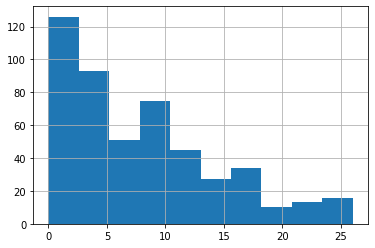

In [77]:
train_X.address.hist()

C:\Users\om\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

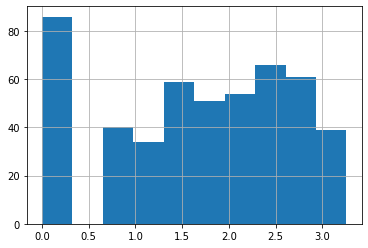

In [78]:
#train_X.address.hist()
ln_address = np.where(train_X.address>0,np.log(train_X.address),0)
pd.Series(ln_address).hist()

In [79]:
nb_model = MultinomialNB()

In [80]:
nb_model.fit(train_X, train_y)

MultinomialNB()

In [81]:
train_pred = nb_model.predict(train_X)

In [82]:
test_pred = nb_model.predict(test_X)

In [83]:
print(metrics.classification_report(train_y, train_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82       358
         1.0       0.53      0.70      0.60       132

    accuracy                           0.75       490
   macro avg       0.70      0.73      0.71       490
weighted avg       0.78      0.75      0.76       490



In [84]:
print(metrics.classification_report(test_y, test_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83       159
         1.0       0.50      0.73      0.59        51

    accuracy                           0.76       210
   macro avg       0.70      0.75      0.71       210
weighted avg       0.80      0.76      0.77       210



In [85]:
train_X

,address,creddebt,debtinc,employ,othdebt
404,10.0,2.099636,15.400,18.0,3.136364
63,9.0,2.159850,7.000,4.0,1.690150
34,1.0,0.077140,2.900,8.0,0.937860
33,4.0,1.018656,14.400,8.0,2.869344
583,14.0,7.320000,30.701,16.0,10.980000
...,...,...,...,...,...
98,9.0,0.681093,6.300,4.0,0.515907
322,22.0,0.431200,1.600,16.0,0.352800
382,12.0,4.003840,16.000,2.0,3.356160
365,13.0,0.428640,1.900,3.0,0.464360


### Decision Trees

In [86]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text

In [87]:
model = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)
model.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)

In [88]:
pred_prob_train = pd.DataFrame(model.predict_proba(train_X))[1]

In [89]:
metrics.roc_auc_score(train_y, pred_prob_train)

0.8345818520399526

In [90]:
pred_prob_test = pd.DataFrame(model.predict_proba(test_X))[1]
metrics.roc_auc_score(test_y, pred_prob_test)

0.7477494142311013

In [91]:
print(metrics.classification_report(train_y, model.predict(train_X)))

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88       358
         1.0       0.75      0.50      0.60       132

    accuracy                           0.82       490
   macro avg       0.79      0.72      0.74       490
weighted avg       0.81      0.82      0.81       490



In [92]:
print(metrics.classification_report(test_y, model.predict(test_X)))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       159
         1.0       0.59      0.33      0.42        51

    accuracy                           0.78       210
   macro avg       0.70      0.63      0.64       210
weighted avg       0.76      0.78      0.76       210



In [93]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(model.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(model.predict_proba(test_X))[1]))

0.8345818520399526
0.7477494142311013


In [94]:
param_grid = {'max_depth': [3,4,5,6,7,8,9,10],
              'max_leaf_nodes': [5,6,7,8,9,10,11,12]
}
#model = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='f1_weighted')
model = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='roc_auc')
model.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='roc_auc')

In [95]:
model.best_params_

{'max_depth': 4, 'max_leaf_nodes': 8}

In [96]:
model.best_score_

0.7765413707315116

In [97]:
model = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)
model.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)

In [98]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(model.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(model.predict_proba(test_X))[1]))

0.8192187235483326
0.7677272166728326


In [99]:
model.feature_importances_

array([0.12810265, 0.17678112, 0.45213554, 0.24298068, 0.        ])

In [100]:
train_X.columns

Index(['address', 'creddebt', 'debtinc', 'employ', 'othdebt'], dtype='object')

In [101]:
var_imp = pd.DataFrame([train_X.columns, model.feature_importances_]).T

In [102]:
var_imp.columns = ['var', 'imp']

In [103]:
var_imp.sort_values(by= 'imp', ascending=False, inplace=True)

<AxesSubplot:>

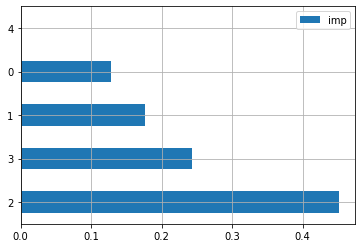

In [104]:
var_imp.plot(kind='barh')

In [105]:
var_imp

,var,imp
2,debtinc,0.452136
3,employ,0.242981
1,creddebt,0.176781
0,address,0.128103
4,othdebt,0.0


### Generate Rules from Decision Trees (Out put as graph)

#### To create a decision tree visualization graph.
- Install GraphViz (As per the OS and version you are using)
- pip install pydotplus
- Add the path to environmental variables
- Note: The notebook needs a restart.

In [106]:
import os     
os.environ["PATH"] += os.pathsep + 'D:/graphviz-2.38/release/bin'

In [107]:
!pip install pydotplus

You should consider upgrading via the 'c:\users\om\anaconda3\python.exe -m pip install --upgrade pip' command.


In [108]:
from sklearn.tree import export_graphviz

In [109]:
# Exporting the tree output in the form opendocument
export_graphviz( model,
              out_file = "model_tree.odt",
              feature_names = train_X.columns )

In [110]:
# Converting open document file to jpg imanage

import pydotplus as pdot
chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'model_tree.odt' )

In [111]:
chd_tree_graph.write_jpg( 'model_tree.jpg' )

True

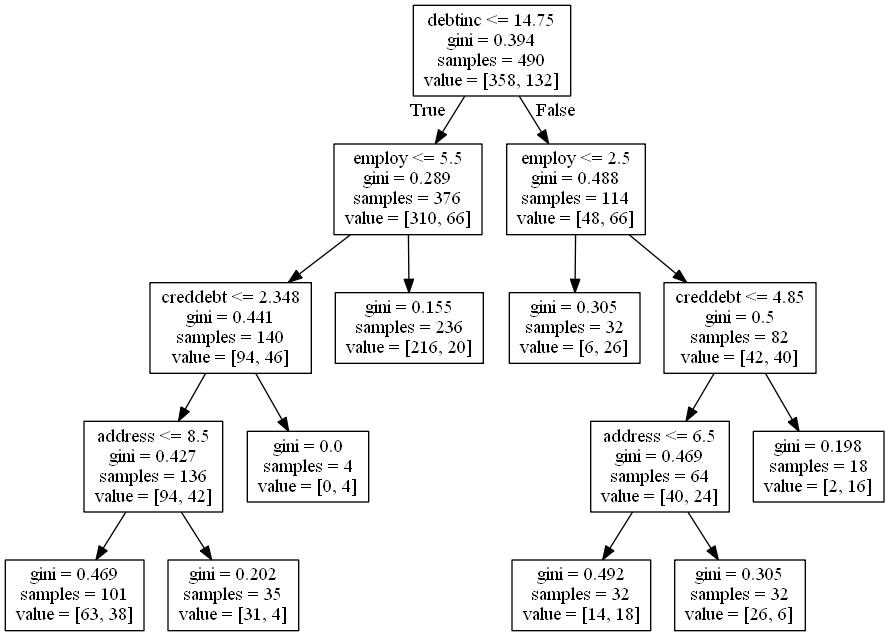

In [112]:
# Viewing the image in the notebook (display the image)
from IPython.display import Image
Image(filename='model_tree.jpg')

In [113]:
model

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=8)

In [114]:
export_graphviz(model, 'dot_data.odt',  
                filled=True, rounded=True,
                special_characters=True,feature_names = train_X.columns,class_names=['0','1'])

In [115]:
import pydotplus
graph = pydotplus.graphviz.graph_from_dot_file('dot_data.odt')  

In [116]:
graph.write_png('tree_final.png')

True

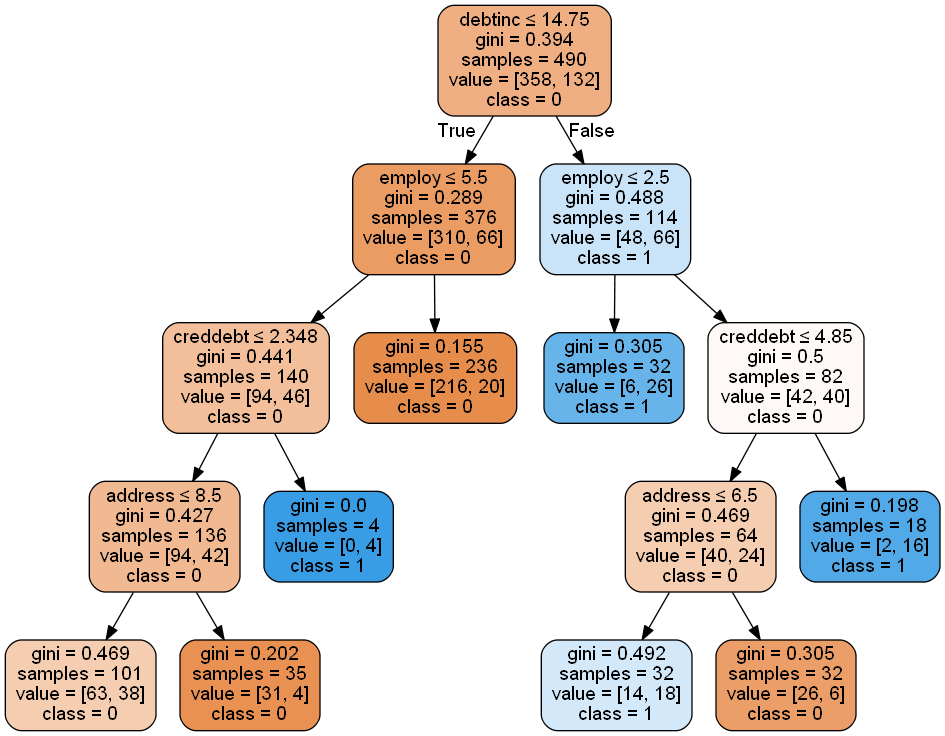

In [117]:
Image('tree_final.png')

In [118]:
from sklearn.tree import export_text

In [119]:
text_representation = export_text(model, feature_names = ['address', 'creddebt', 'debtinc', 'employ', 'othdebt'])
print(text_representation)

|--- debtinc <= 14.75
|   |--- employ <= 5.50
|   |   |--- creddebt <= 2.35
|   |   |   |--- address <= 8.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- address >  8.50
|   |   |   |   |--- class: 0.0
|   |   |--- creddebt >  2.35
|   |   |   |--- class: 1.0
|   |--- employ >  5.50
|   |   |--- class: 0.0
|--- debtinc >  14.75
|   |--- employ <= 2.50
|   |   |--- class: 1.0
|   |--- employ >  2.50
|   |   |--- creddebt <= 4.85
|   |   |   |--- address <= 6.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- address >  6.50
|   |   |   |   |--- class: 0.0
|   |   |--- creddebt >  4.85
|   |   |   |--- class: 1.0



In [120]:
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)

In [121]:
import sklearn.tree as tree

In [122]:
from sklearn.tree import plot_tree

In [123]:
import matplotlib.pyplot as plt

[Text(182.61818181818182, 195.696, 'debtinc <= 14.75\ngini = 0.394\nsamples = 490\nvalue = [358, 132]\nclass = y'),
 Text(121.74545454545455, 152.208, 'employ <= 5.5\ngini = 0.289\nsamples = 376\nvalue = [310, 66]\nclass = y'),
 Text(91.30909090909091, 108.72, 'creddebt <= 2.348\ngini = 0.441\nsamples = 140\nvalue = [94, 46]\nclass = y'),
 Text(60.872727272727275, 65.232, 'address <= 8.5\ngini = 0.427\nsamples = 136\nvalue = [94, 42]\nclass = y'),
 Text(30.436363636363637, 21.744, 'gini = 0.469\nsamples = 101\nvalue = [63, 38]\nclass = y'),
 Text(91.30909090909091, 21.744, 'gini = 0.202\nsamples = 35\nvalue = [31, 4]\nclass = y'),
 Text(121.74545454545455, 65.232, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = e'),
 Text(152.1818181818182, 108.72, 'gini = 0.155\nsamples = 236\nvalue = [216, 20]\nclass = y'),
 Text(243.4909090909091, 152.208, 'employ <= 2.5\ngini = 0.488\nsamples = 114\nvalue = [48, 66]\nclass = e'),
 Text(213.05454545454546, 108.72, 'gini = 0.305\nsamples = 32\nvalu

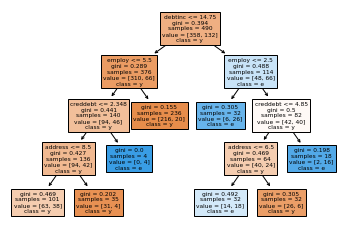

In [124]:
tree.plot_tree(model, 
                   feature_names=train_X.columns,  
                   class_names='yes',
                   filled=True)

In [125]:
model.tree_.node_count

15

In [126]:
model.tree_.n_leaves

8

In [127]:
n_nodes = model.tree_.node_count

children_left = model.tree_.children_left

children_right = model.tree_.children_right

feature = model.tree_.feature

threshold = model.tree_.threshold

In [128]:
print(n_nodes)
print(children_left)
print(children_right)
print(feature)
print(threshold)

15
[ 1  3  5 11 -1 -1  7  9 -1 -1 -1 13 -1 -1 -1]
[ 2  4  6 12 -1 -1  8 10 -1 -1 -1 14 -1 -1 -1]
[ 2  3  3  1 -2 -2  1  0 -2 -2 -2  0 -2 -2 -2]
[14.75        5.5         2.5         2.34770405 -2.         -2.
  4.85020256  6.5        -2.         -2.         -2.          8.5
 -2.         -2.         -2.        ]


In [129]:
def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False

        if (children_left[node_numb] !=-1):
            left = find_path(children_left[node_numb], path, x)

        if (children_right[node_numb] !=-1):
            right = find_path(children_right[node_numb], path, x)

        if left or right :
            return True

        path.remove(node_numb)
        return False

In [130]:
def get_rule(path, column_names):

    mask = ''
    for index, node in enumerate(path):
        #We check if we are not in the leaf

        if index!=len(path)-1:
            # Do we go under or over the threshold ?

            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])

            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])

    # We insert the & at the right places

    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")

    return mask

In [131]:
# Leaves

leave_id = model.apply(train_X)

In [132]:
paths ={}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))
rules = {}

In [133]:
for key in paths:
    rules[key] = get_rule(paths[key], train_X.columns)


In [134]:
rules

{4: "(df['debtinc']<= 14.75) & (df['employ']> 5.5)  ",
 5: "(df['debtinc']> 14.75) & (df['employ']<= 2.5)  ",
 8: "(df['debtinc']> 14.75) & (df['employ']> 2.5) & (df['creddebt']> 4.850202560424805)  ",
 9: "(df['debtinc']> 14.75) & (df['employ']> 2.5) & (df['creddebt']<= 4.850202560424805) & (df['address']<= 6.5)  ",
 10: "(df['debtinc']> 14.75) & (df['employ']> 2.5) & (df['creddebt']<= 4.850202560424805) & (df['address']> 6.5)  ",
 12: "(df['debtinc']<= 14.75) & (df['employ']<= 5.5) & (df['creddebt']> 2.34770405292511)  ",
 13: "(df['debtinc']<= 14.75) & (df['employ']<= 5.5) & (df['creddebt']<= 2.34770405292511) & (df['address']<= 8.5)  ",
 14: "(df['debtinc']<= 14.75) & (df['employ']<= 5.5) & (df['creddebt']<= 2.34770405292511) & (df['address']> 8.5)  "}

In [135]:
#Exercise: Apply Decision trees, KNN, Naive Bayes
#1. You need to implement on HR Data set  - Classificaiton
#2. Take the regression problem (predicting intrest rate) - Regression

# Ensemble Learning

### Bagging

In [136]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor,RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor 

### Tuning parameters

In [137]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys()) 

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [138]:
pargrid_ada = {'n_estimators': [50, 60, 70, 80, 90, 100]}

gscv_bagging = GridSearchCV(estimator=BaggingClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=5,
                        verbose=True, n_jobs=-1, scoring='roc_auc')

In [139]:
gscv_results = gscv_bagging.fit(train_X, train_y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [140]:
gscv_results.best_params_

{'n_estimators': 90}

In [141]:
gscv_results.best_score_

0.8064864973315677

In [142]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(gscv_results.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(gscv_results.predict_proba(test_X))[1]))

1.0
0.7898014551732643


## Random Forest

##### Important Tuning Parameters for Random Forest: 
- criterion - measure for quality of a split
- max_depth - The maximum depth of the tree.
- max_leaf_nodes - Number of features to consider when looking for the best split
- min_samples_leaf - The minimum number of samples required to be a leaf node. This may have effect of smoothing the model.
- min_sample_split - The minimum number of samples required to split an internal node.
- n_estimators - The number of trees in the forest
- max_features - Number of features to consider when looking for the best split

In [143]:
from sklearn.ensemble import RandomForestClassifier

radm_clf = RandomForestClassifier(oob_score=True,n_estimators=100 , max_depth = 10, max_features=4, n_jobs=-1)
radm_clf.fit( train_X, train_y )

RandomForestClassifier(max_depth=10, max_features=4, n_jobs=-1, oob_score=True)

In [144]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(radm_clf.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(radm_clf.predict_proba(test_X))[1]))

1.0
0.7936243679861882


### Feature importance from the Random Forest Model

In [145]:
radm_clf.feature_importances_

array([0.11003148, 0.21096093, 0.31104896, 0.18944056, 0.17851806])

In [146]:
train_X.columns

Index(['address', 'creddebt', 'debtinc', 'employ', 'othdebt'], dtype='object')

In [147]:
radm_clf.feature_importances_

indices = np.argsort(radm_clf.feature_importances_)[::-1]

In [148]:
import seaborn as sn

<AxesSubplot:xlabel='importance', ylabel='feature'>

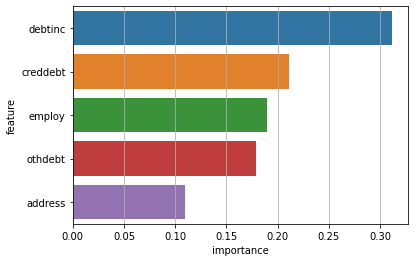

In [149]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_X.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_X.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]
sn.barplot( y = 'feature', x = 'importance', data = feature_rank )

### Tuning parameters

In [150]:
pargrid_ada = {'n_estimators': [50, 60, 70, 80, 90, 100],
                'max_features': [2,3,4],
              'max_depth': [2,3,4,5,6]}
gscv_Rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=5,
                        verbose=True, n_jobs=-1, scoring='roc_auc')

In [151]:
gscv_results = gscv_Rf.fit(train_X, train_y)
gscv_results.best_score_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


0.830716564343325

In [152]:
gscv_results.best_params_

{'max_depth': 4, 'max_features': 2, 'n_estimators': 100}

In [153]:
gscv_results.predict(train_X)

array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [154]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(gscv_results.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(gscv_results.predict_proba(test_X))[1]))

0.9199043507702725
0.8140337896164755


In [155]:
import pickle

In [156]:
%pwd

'C:\\Users\\om\\Desktop\\Bootcamp - Aug\\1. Case Study - Bank Loans'

In [157]:
# now you can save it to a file
with open('RF_Model.pkl', 'wb') as f:
    pickle.dump(gscv_results, f)

In [158]:
with open('RF_Model.pkl', 'rb') as f:
    model1 = pickle.load(f)

### Boosting

#### Ada Boosting

In [159]:
pargrid_ada = {'n_estimators': [100, 200, 400, 600, 800],
               'learning_rate': [10 ** x for x in range(-3, 3)]}

In [160]:
gscv_ada = GridSearchCV(estimator=AdaBoostClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=5,
                        verbose=True, n_jobs=-1)

In [161]:
gscv_ada.fit(train_X, train_y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\om\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.76734694 0.76938776 0.75102041 0.75102041 0.77346939 0.77346939
 0.77755102 0.78571429 0.79387755 0.79591837 0.8        0.79795918
 0.79795918 0.8        0.79387755 0.76734694 0.76326531 0.76938776
 0.76530612 0.75918367 0.23877551 0.23877551 0.23877551 0.23877551
 0.23877551        nan        nan        nan        nan        nan]
  category=UserWarning


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
                         'n_estimators': [100, 200, 400, 600, 800]},
             verbose=True)

In [162]:
gscv_ada.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [163]:
clf_ada = gscv_ada.best_estimator_

In [164]:
gscv_ada.best_score_

0.8

In [165]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(gscv_ada.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(gscv_ada.predict_proba(test_X))[1]))

0.8942039106145251
0.8347515106671599


In [166]:
ad=AdaBoostClassifier(learning_rate = 0.1, n_estimators=100)
ad.fit(train_X, train_y )

AdaBoostClassifier(learning_rate=0.1, n_estimators=100)

In [167]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(ad.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(ad.predict_proba(test_X))[1]))

0.8942039106145251
0.8347515106671599


### Gradient Boost

##### Important Tuning Parameters for GBM: 
- learning_rate - the effect of each tree on the outcome is shrunk by this factor.
- criterion - measure for quality of a split
- max_depth - The maximum depth of the tree.
- max_leaf_nodes - Number of features to consider when looking for the best split
- min_samples_leaf - The minimum number of samples required to be a leaf node. This may have effect of smoothing the model.
- min_sample_split - The minimum number of samples required to split an internal node.
- n_estimators - The number of trees in the forest
- max_features - Number of features to consider when looking for the best split

In [168]:
pargrid_ada = {'n_estimators': [100, 200, 400, 600, 800],
               'learning_rate': [10 ** x for x in range(-3, 3)],
              'max_features' : [2,3,4]}

In [169]:
gscv_gbm = GridSearchCV(estimator=GradientBoostingClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=5,
                        verbose=True, n_jobs=-1)

gscv_gbm.fit(train_X, train_y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_features': [2, 3, 4],
                         'n_estimators': [100, 200, 400, 600, 800]},
             verbose=True)

In [170]:
gscv_gbm.best_params_

{'learning_rate': 0.01, 'max_features': 4, 'n_estimators': 800}

In [171]:
clf_gbm = gscv_gbm.best_estimator_

gscv_gbm.best_score_

0.7959183673469388

In [172]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(gscv_gbm.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(gscv_gbm.predict_proba(test_X))[1]))

0.9822456407651938
0.8155136268343816


In [173]:
gbm=GradientBoostingClassifier(learning_rate = 0.01, n_estimators=400)
gbm.fit(train_X, train_y )

GradientBoostingClassifier(learning_rate=0.01, n_estimators=400)

In [174]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(gscv_gbm.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(gscv_gbm.predict_proba(test_X))[1]))

0.9822456407651938
0.8155136268343816


## XGBOOSt

XGBoost (extreme Gradient Boosting) is an advanced implementation of the gradient boosting algorithm. XGBoost has proved to be a highly effective ML algorithm, extensively used in machine learning competitions and hackathons. XGBoost has high predictive power and is almost 10 times faster than the other gradient boosting techniques. It also includes a variety of regularization which reduces overfitting and improves overall performance. Hence it is also known as ‘regularized boosting‘ technique.

Let us see how XGBoost is comparatively better than other techniques:

#### Regularization:
Standard GBM implementation has no regularisation like XGBoost.
Thus XGBoost also helps to reduce overfitting.
#### Parallel Processing:
XGBoost implements parallel processing and is faster than GBM .
XGBoost also supports implementation on Hadoop.
#### High Flexibility:
XGBoost allows users to define custom optimization objectives and evaluation criteria adding a whole new dimension to the model.
#### Handling Missing Values:
XGBoost has an in-built routine to handle missing values.
#### Tree Pruning:
XGBoost makes splits up to the max_depth specified and then starts pruning the tree backwards and removes splits beyond which there is no positive gain.
#### Built-in Cross-Validation:
XGBoost allows a user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.

Since XGBoost takes care of the missing values itself, you do not have to impute the missing values. You can skip the step for missing value imputation. 

In [175]:
!pip install xgboost

You should consider upgrading via the 'c:\users\om\anaconda3\python.exe -m pip install --upgrade pip' command.


In [176]:
from xgboost import XGBClassifier, XGBRegressor

##### Important Tuning Parameters for XGBOOST: 
- nthread: This is used for parallel processing and the number of cores in the system should be entered.If you wish to run on all cores, do not input this value. The algorithm will detect it automatically
- eta: Analogous to learning rate in GBM.Makes the model more robust by shrinking the weights on each step.
- min_child_weight: Defines the minimum sum of weights of all observations required in a child. Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
- learning_rate - Boosting Learning rate.
- criterion - measure for quality of a split
- max_depth - The maximum depth of the tree.
- max_leaf_nodes - Number of features to consider when looking for the best split
- min_samples_leaf - The minimum number of samples required to be a leaf node. This may have effect of smoothing the model.
- min_sample_split - The minimum number of samples required to split an internal node.
- n_estimators - The number of trees in the forest
- max_features - Number of features to consider when looking for the best split
- gamma - Minimum loss reduction required to make a further partition on a leaf node of the tree.
- subsample - Denotes the fraction of observations to be randomly samples for each tree.
- colsample_bytree - It is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
- reg_alpa - L1 regularization term on weights. Increasing this value will make model more conservative. 
- reg_lambda - L2 regularization term on weights. Increasing this value will make model more conservative.
- scale_pos_weight - Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances).



In [177]:
#All Columns
xgb_estimator = XGBClassifier(n_estimators=200,
                         random_state = 42,
                        n_jobs=-1,
                        verbose=1)


In [178]:
test_X = test_X[test_X.columns.difference(['pred_prob'])]

In [179]:
xgb_estimator.fit(train_X, train_y)

XGBClassifier(n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [180]:
xgb_estimator.predict(train_X)

array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1.

In [181]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(xgb_estimator.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(xgb_estimator.predict_proba(test_X))[1]))

0.9941171491450821
0.807004562831422


In [182]:
# with all tuning parameters

In [183]:
xgb_estimator = XGBClassifier( learning_rate=0.01,
                               n_estimators=1000,
                               max_depth=5,
                               min_child_weight=1,
                               gamma=1,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               n_jobs=-1,
                               reg_alpa=1,
                               scale_pos_weight=1,
                               random_state=42,
                               verbose=1)

In [184]:
xgb_estimator.fit(train_X, train_y)

XGBClassifier(colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=5,
              n_estimators=1000, n_jobs=-1, random_state=42, reg_alpa=1,
              subsample=0.8, verbose=1)

In [185]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(xgb_estimator.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(xgb_estimator.predict_proba(test_X))[1]))

0.9967199932283731
0.8081144407448514


In [186]:
print(metrics.classification_report(train_y, xgb_estimator.predict(train_X)))

print(metrics.classification_report(test_y, xgb_estimator.predict(test_X)))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       358
         1.0       1.00      0.89      0.94       132

    accuracy                           0.97       490
   macro avg       0.98      0.94      0.96       490
weighted avg       0.97      0.97      0.97       490

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       159
         1.0       0.61      0.43      0.51        51

    accuracy                           0.80       210
   macro avg       0.72      0.67      0.69       210
weighted avg       0.78      0.80      0.78       210



In [187]:
param_grid = {'learning_rate' : [0.01, 0.05, 0.1],
                               'n_estimators' : [100,200,300]}

#param_grid = {'learning_rate' : [0.01, 0.05, 0.1],
#                               'n_estimators' : [100,200,300],
#                               'max_depth' : [2,3,4],
#                               'min_child_weight' :[0.3,0.4,0.5],
#                               'gamma' : [0.5,0.6, 1],
#                               'subsample' : [0.6,0.7, 0.8],
#                               'colsample_bytree': [0.7,0.8],
#                               'reg_alpa': [0.4,0.5, 0.7, 0.8,1]}

xgcv = GridSearchCV(XGBClassifier(), param_grid, cv=5)

xgcv.fit(train_X, train_y)

print(xgcv.best_params_)

print(xgcv.best_score_)

#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(xgcv.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(xgcv.predict_proba(test_X))[1]))

{'learning_rate': 0.01, 'n_estimators': 100}
0.7979591836734693
0.8846072456407652
0.7811074115180664


### Hetrogenious Ensemble Models

In [188]:
from sklearn.ensemble import VotingClassifier, VotingRegressor

In [189]:
voting_clf = VotingClassifier(estimators = [('logreg',model), ('radm_clf',radm_clf), ('adaboost', ad), ('xgbm',xgb_estimator)], voting = 'hard')
voting_clf.fit(train_X, train_y)

VotingClassifier(estimators=[('logreg',
                              DecisionTreeClassifier(max_depth=4,
                                                     max_leaf_nodes=8)),
                             ('radm_clf',
                              RandomForestClassifier(max_depth=10,
                                                     max_features=4, n_jobs=-1,
                                                     oob_score=True)),
                             ('adaboost',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=100)),
                             ('xgbm',
                              XGBClassifier(colsample_bytree=0.8, gamma=1,
                                            learning_rate=0.01, max_depth=5,
                                            n_estimators=1000, n_jobs=-1,
                                            random_state=42, reg_alpa=1,
                                            s

In [190]:
print(metrics.accuracy_score(test_y,voting_clf.predict(test_X)))
print(metrics.roc_auc_score(test_y,voting_clf.predict(test_X)))

0.8285714285714286
0.6870144284128745


### Light GBM
Light GBM beats all the other algorithms when the dataset is extremely large. Compared to the other algorithms, Light GBM takes lesser time to run on a huge dataset.

LightGBM is a gradient boosting framework that uses tree-based algorithms and follows leaf-wise approach while other algorithms work in a level-wise approach pattern. 

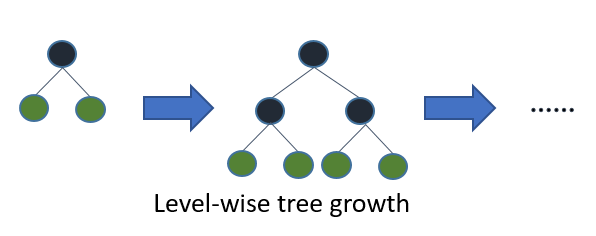

In [191]:
Image('lightGBM.png')

Leaf-wise growth may cause over-fitting on smaller datasets but that can be avoided by using the ‘max_depth’ parameter for learning. 

Parameters

#### num_iterations:
It defines the number of boosting iterations to be performed.
#### num_leaves :
This parameter is used to set the number of leaves to be formed in a tree.
In case of Light GBM, since splitting takes place leaf-wise rather than depth-wise, num_leaves must be smaller than 2^(max_depth), otherwise, it may lead to overfitting.
#### min_data_in_leaf :
A very small value may cause overfitting.
It is also one of the most important parameters in dealing with overfitting.
#### max_depth:
It specifies the maximum depth or level up to which a tree can grow.
A very high value for this parameter can cause overfitting.
#### bagging_fraction:
It is used to specify the fraction of data to be used for each iteration.
This parameter is generally used to speed up the training.
#### max_bin :
Defines the max number of bins that feature values will be bucketed in.
A smaller value of max_bin can save a lot of time as it buckets the feature values in discrete bins which is computationally inexpensive.

In [193]:
!pip install lightgbm

You should consider upgrading via the 'c:\users\om\anaconda3\python.exe -m pip install --upgrade pip' command.


In [194]:
import lightgbm as lgb
train_data=lgb.Dataset(train_X,label=train_y)
#define parameters
params = {'learning_rate':0.001}
model= lgb.train(params, train_data, 100) 
y_pred=model.predict(test_X)

In [195]:
y_pred

array([0.24372609, 0.24608578, 0.29062191, 0.29900323, 0.24715205,
       0.266249  , 0.24715205, 0.28960017, 0.25498967, 0.31222745,
       0.29490695, 0.32088483, 0.25772644, 0.27738417, 0.27305864,
       0.28954715, 0.25017282, 0.2635391 , 0.28735911, 0.24801154,
       0.3128611 , 0.24373081, 0.24715205, 0.26467226, 0.25144648,
       0.266249  , 0.28937092, 0.28954715, 0.29696917, 0.24715205,
       0.31222745, 0.25017282, 0.25928409, 0.24370067, 0.24560373,
       0.24372414, 0.24370305, 0.24372536, 0.24372417, 0.25724908,
       0.2437386 , 0.24374016, 0.24372534, 0.24541884, 0.27738417,
       0.24750814, 0.25144648, 0.24373075, 0.32118061, 0.26798432,
       0.28735911, 0.28735911, 0.26467226, 0.29923248, 0.25394183,
       0.24371516, 0.27715492, 0.26467226, 0.2589999 , 0.28937092,
       0.2626382 , 0.2626382 , 0.27305864, 0.29696917, 0.29923248,
       0.27512086, 0.2454248 , 0.27305864, 0.27738417, 0.25498967,
       0.25340091, 0.29923248, 0.32088483, 0.26135106, 0.24608

### CatBoost
Handling categorical variables is a tedious process, especially when you have a large number of such variables. When your categorical variables have too many labels (i.e. they are highly cardinal), performing one-hot-encoding on them exponentially increases the dimensionality and it becomes really difficult to work with the dataset.

CatBoost can automatically deal with categorical variables and does not require extensive data preprocessing like other machine learning algorithms

CatBoost algorithm effectively deals with categorical variables. Thus, you should not perform one-hot encoding for categorical variables. Just load the files, impute missing values, and you’re good to go.

Parameters

#### loss_function:
Defines the metric to be used for training.
#### iterations:
The maximum number of trees that can be built.
The final number of trees may be less than or equal to this number.
#### learning_rate:
Defines the learning rate.
Used for reducing the gradient step.
#### border_count:
It specifies the number of splits for numerical features.
It is similar to the max_bin parameter.
#### depth:
Defines the depth of the trees.
#### random_seed:
This parameter is similar to the ‘random_state’ parameter we have seen previously.
It is an integer value to define the random seed for training.

In [197]:
!pip install catboost

You should consider upgrading via the 'c:\users\om\anaconda3\python.exe -m pip install --upgrade pip' command.


In [199]:
from catboost import CatBoostClassifier
model=CatBoostClassifier()
categorical_features_indices = np.where(train_X.dtypes != np.float)[0]
model.fit(train_X,train_y,cat_features=(categorical_features_indices),eval_set=(test_X, test_y))
model.score(test_X,test_y)

C:\Users\om\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


Learning rate set to 0.02657
0:	learn: 0.6771241	test: 0.6785437	best: 0.6785437 (0)	total: 57.3ms	remaining: 57.3s
1:	learn: 0.6605780	test: 0.6654168	best: 0.6654168 (1)	total: 59.9ms	remaining: 29.9s
2:	learn: 0.6463679	test: 0.6516797	best: 0.6516797 (2)	total: 62.2ms	remaining: 20.7s
3:	learn: 0.6325668	test: 0.6384606	best: 0.6384606 (3)	total: 64.6ms	remaining: 16.1s
4:	learn: 0.6208951	test: 0.6264990	best: 0.6264990 (4)	total: 67.3ms	remaining: 13.4s
5:	learn: 0.6092613	test: 0.6153195	best: 0.6153195 (5)	total: 69.6ms	remaining: 11.5s
6:	learn: 0.5993430	test: 0.6068125	best: 0.6068125 (6)	total: 72.3ms	remaining: 10.3s
7:	learn: 0.5867753	test: 0.5965354	best: 0.5965354 (7)	total: 74.8ms	remaining: 9.27s
8:	learn: 0.5772622	test: 0.5886158	best: 0.5886158 (8)	total: 77.1ms	remaining: 8.49s
9:	learn: 0.5677598	test: 0.5801350	best: 0.5801350 (9)	total: 79.4ms	remaining: 7.86s
10:	learn: 0.5590822	test: 0.5721585	best: 0.5721585 (10)	total: 81.8ms	remaining: 7.36s
11:	learn: 0

120:	learn: 0.3148351	test: 0.4373191	best: 0.4363514 (106)	total: 315ms	remaining: 2.29s
121:	learn: 0.3142054	test: 0.4375044	best: 0.4363514 (106)	total: 318ms	remaining: 2.29s
122:	learn: 0.3133575	test: 0.4374406	best: 0.4363514 (106)	total: 320ms	remaining: 2.28s
123:	learn: 0.3130048	test: 0.4376647	best: 0.4363514 (106)	total: 323ms	remaining: 2.28s
124:	learn: 0.3124479	test: 0.4372298	best: 0.4363514 (106)	total: 325ms	remaining: 2.27s
125:	learn: 0.3116080	test: 0.4371509	best: 0.4363514 (106)	total: 327ms	remaining: 2.27s
126:	learn: 0.3110173	test: 0.4371470	best: 0.4363514 (106)	total: 330ms	remaining: 2.27s
127:	learn: 0.3094730	test: 0.4368367	best: 0.4363514 (106)	total: 333ms	remaining: 2.27s
128:	learn: 0.3087478	test: 0.4365613	best: 0.4363514 (106)	total: 335ms	remaining: 2.26s
129:	learn: 0.3081706	test: 0.4370190	best: 0.4363514 (106)	total: 337ms	remaining: 2.26s
130:	learn: 0.3071711	test: 0.4367900	best: 0.4363514 (106)	total: 340ms	remaining: 2.25s
131:	learn

267:	learn: 0.2173888	test: 0.4513295	best: 0.4363514 (106)	total: 622ms	remaining: 1.7s
268:	learn: 0.2168916	test: 0.4515594	best: 0.4363514 (106)	total: 625ms	remaining: 1.7s
269:	learn: 0.2164473	test: 0.4517421	best: 0.4363514 (106)	total: 627ms	remaining: 1.7s
270:	learn: 0.2159001	test: 0.4519616	best: 0.4363514 (106)	total: 630ms	remaining: 1.69s
271:	learn: 0.2155091	test: 0.4521370	best: 0.4363514 (106)	total: 632ms	remaining: 1.69s
272:	learn: 0.2153269	test: 0.4520822	best: 0.4363514 (106)	total: 635ms	remaining: 1.69s
273:	learn: 0.2145257	test: 0.4519190	best: 0.4363514 (106)	total: 637ms	remaining: 1.69s
274:	learn: 0.2137539	test: 0.4523282	best: 0.4363514 (106)	total: 639ms	remaining: 1.69s
275:	learn: 0.2129424	test: 0.4521820	best: 0.4363514 (106)	total: 642ms	remaining: 1.68s
276:	learn: 0.2124406	test: 0.4523823	best: 0.4363514 (106)	total: 644ms	remaining: 1.68s
277:	learn: 0.2121483	test: 0.4524398	best: 0.4363514 (106)	total: 647ms	remaining: 1.68s
278:	learn: 0

390:	learn: 0.1636206	test: 0.4614715	best: 0.4363514 (106)	total: 963ms	remaining: 1.5s
391:	learn: 0.1633039	test: 0.4617718	best: 0.4363514 (106)	total: 967ms	remaining: 1.5s
392:	learn: 0.1629987	test: 0.4617409	best: 0.4363514 (106)	total: 970ms	remaining: 1.5s
393:	learn: 0.1624075	test: 0.4620555	best: 0.4363514 (106)	total: 974ms	remaining: 1.5s
394:	learn: 0.1620491	test: 0.4623468	best: 0.4363514 (106)	total: 978ms	remaining: 1.5s
395:	learn: 0.1614032	test: 0.4622057	best: 0.4363514 (106)	total: 981ms	remaining: 1.5s
396:	learn: 0.1610475	test: 0.4620711	best: 0.4363514 (106)	total: 985ms	remaining: 1.5s
397:	learn: 0.1605771	test: 0.4622542	best: 0.4363514 (106)	total: 988ms	remaining: 1.49s
398:	learn: 0.1599493	test: 0.4623632	best: 0.4363514 (106)	total: 991ms	remaining: 1.49s
399:	learn: 0.1597440	test: 0.4624046	best: 0.4363514 (106)	total: 1.03s	remaining: 1.54s
400:	learn: 0.1595086	test: 0.4621479	best: 0.4363514 (106)	total: 1.04s	remaining: 1.56s
401:	learn: 0.159

532:	learn: 0.1193148	test: 0.4775772	best: 0.4363514 (106)	total: 1.45s	remaining: 1.27s
533:	learn: 0.1190077	test: 0.4773239	best: 0.4363514 (106)	total: 1.45s	remaining: 1.26s
534:	learn: 0.1185581	test: 0.4774398	best: 0.4363514 (106)	total: 1.45s	remaining: 1.26s
535:	learn: 0.1182781	test: 0.4776396	best: 0.4363514 (106)	total: 1.45s	remaining: 1.26s
536:	learn: 0.1180720	test: 0.4778754	best: 0.4363514 (106)	total: 1.46s	remaining: 1.26s
537:	learn: 0.1179670	test: 0.4778981	best: 0.4363514 (106)	total: 1.46s	remaining: 1.25s
538:	learn: 0.1176412	test: 0.4779444	best: 0.4363514 (106)	total: 1.46s	remaining: 1.25s
539:	learn: 0.1171834	test: 0.4779166	best: 0.4363514 (106)	total: 1.47s	remaining: 1.25s
540:	learn: 0.1171234	test: 0.4779133	best: 0.4363514 (106)	total: 1.47s	remaining: 1.25s
541:	learn: 0.1166539	test: 0.4782773	best: 0.4363514 (106)	total: 1.47s	remaining: 1.24s
542:	learn: 0.1166423	test: 0.4782657	best: 0.4363514 (106)	total: 1.47s	remaining: 1.24s
543:	learn

665:	learn: 0.0905882	test: 0.4904411	best: 0.4363514 (106)	total: 1.76s	remaining: 884ms
666:	learn: 0.0904132	test: 0.4907225	best: 0.4363514 (106)	total: 1.76s	remaining: 881ms
667:	learn: 0.0901371	test: 0.4905379	best: 0.4363514 (106)	total: 1.77s	remaining: 878ms
668:	learn: 0.0898992	test: 0.4909602	best: 0.4363514 (106)	total: 1.77s	remaining: 876ms
669:	learn: 0.0895797	test: 0.4915347	best: 0.4363514 (106)	total: 1.77s	remaining: 873ms
670:	learn: 0.0893622	test: 0.4919357	best: 0.4363514 (106)	total: 1.77s	remaining: 870ms
671:	learn: 0.0892553	test: 0.4921246	best: 0.4363514 (106)	total: 1.78s	remaining: 867ms
672:	learn: 0.0891369	test: 0.4921441	best: 0.4363514 (106)	total: 1.78s	remaining: 865ms
673:	learn: 0.0890287	test: 0.4923769	best: 0.4363514 (106)	total: 1.78s	remaining: 862ms
674:	learn: 0.0888425	test: 0.4925979	best: 0.4363514 (106)	total: 1.79s	remaining: 860ms
675:	learn: 0.0887742	test: 0.4926086	best: 0.4363514 (106)	total: 1.79s	remaining: 858ms
676:	learn

803:	learn: 0.0708436	test: 0.5059538	best: 0.4363514 (106)	total: 2.08s	remaining: 507ms
804:	learn: 0.0708138	test: 0.5060432	best: 0.4363514 (106)	total: 2.08s	remaining: 504ms
805:	learn: 0.0706249	test: 0.5062849	best: 0.4363514 (106)	total: 2.08s	remaining: 501ms
806:	learn: 0.0704528	test: 0.5061677	best: 0.4363514 (106)	total: 2.08s	remaining: 499ms
807:	learn: 0.0704196	test: 0.5061567	best: 0.4363514 (106)	total: 2.09s	remaining: 496ms
808:	learn: 0.0702797	test: 0.5060980	best: 0.4363514 (106)	total: 2.09s	remaining: 494ms
809:	learn: 0.0701966	test: 0.5062390	best: 0.4363514 (106)	total: 2.09s	remaining: 491ms
810:	learn: 0.0700013	test: 0.5065289	best: 0.4363514 (106)	total: 2.1s	remaining: 488ms
811:	learn: 0.0698595	test: 0.5069555	best: 0.4363514 (106)	total: 2.1s	remaining: 486ms
812:	learn: 0.0698333	test: 0.5069097	best: 0.4363514 (106)	total: 2.1s	remaining: 483ms
813:	learn: 0.0697545	test: 0.5068805	best: 0.4363514 (106)	total: 2.1s	remaining: 481ms
814:	learn: 0.

949:	learn: 0.0570526	test: 0.5224761	best: 0.4363514 (106)	total: 2.39s	remaining: 126ms
950:	learn: 0.0569607	test: 0.5225126	best: 0.4363514 (106)	total: 2.4s	remaining: 123ms
951:	learn: 0.0568524	test: 0.5224336	best: 0.4363514 (106)	total: 2.4s	remaining: 121ms
952:	learn: 0.0567131	test: 0.5225408	best: 0.4363514 (106)	total: 2.4s	remaining: 118ms
953:	learn: 0.0565551	test: 0.5224780	best: 0.4363514 (106)	total: 2.4s	remaining: 116ms
954:	learn: 0.0565065	test: 0.5225690	best: 0.4363514 (106)	total: 2.4s	remaining: 113ms
955:	learn: 0.0563456	test: 0.5227478	best: 0.4363514 (106)	total: 2.41s	remaining: 111ms
956:	learn: 0.0562577	test: 0.5227875	best: 0.4363514 (106)	total: 2.41s	remaining: 108ms
957:	learn: 0.0561850	test: 0.5227915	best: 0.4363514 (106)	total: 2.41s	remaining: 106ms
958:	learn: 0.0561284	test: 0.5227522	best: 0.4363514 (106)	total: 2.42s	remaining: 103ms
959:	learn: 0.0560943	test: 0.5227748	best: 0.4363514 (106)	total: 2.42s	remaining: 101ms
960:	learn: 0.0

0.819047619047619

## Support Vector Machines (SVC)

##### Important Tuning Parameters for Support Vector Classifier: 
- C - C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly
- class_weight - Weights associated with classes in the form class_label : Weight. If not given, all classes are supposed to have weight one.
- degree - degree is a parameter used when kernel is set to poly. It’s basically the degree of the polynomial used to find the hyperplane to split the data.
- gamma - kernel coefficient for rbf, ploy and sigmoid to handle non-linear classification
- kernel - This selects the type of hyperplane used to separate the data.
- tol - tolerance for stopping criterion.

In [1]:
#sklern.svm
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR

In [ ]:
model = SVC(kernel='rbf', class_weight='balanced', probability=True)

In [ ]:
model.fit(train_X, train_y)

In [ ]:
#Train data - AUC Score
print(metrics.roc_auc_score(train_y, pd.DataFrame(model.predict_proba(train_X))[1]))

#Test data - AUC Score
print(metrics.roc_auc_score(test_y, pd.DataFrame(model.predict_proba(test_X))[1]))

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10, 50],
              'kernel': ['rbf', 'poly', 'linear'],
             'degree' :[1,2,3] }
model = SVC()
grid = GridSearchCV(model, param_grid)

grid.fit(train_X, train_y)

In [ ]:
print(grid.best_params_)

In [ ]:
model = grid.best_estimator_
yfit = model.predict(test_X)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, yfit))

## Artificial Neural Networks (ANN) using sklearn

##### Important Tuning Parameters for ANN using SKLearn: 
- hidden_layer_size - The number of neurons in the hidden layer.
- learning_rate - option to use different learning rate for weight updates.
- max_iter - maximum number of iterations. This will decide  when to stop the solver, either the solver converges or this maximum number of iterations.
- momentum - momentum for gradient descent update. This will try to avoid trap the local minimum.
- solver - The option to choose different algorithm for weight optimization.
- batch_size - size of minibatches for stochastic optimizer. This is the option that will decide how much samples will be used in online learning
- alpha - This parameter controls the regularization which help avoiding Overfitting.
- activation - This is to define different activation functions.

In [ ]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(train_X)

In [ ]:
# Now apply the transformations to the data:
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

In [ ]:
MLPClassifier?

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [ ]:
mlp.fit(train_X,train_y)

In [ ]:
predictions = mlp.predict(test_X)

In [ ]:
test_X.shape

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_y,predictions))

In [ ]:
print(classification_report(test_y,predictions))

In [ ]:
mlp.coefs_

In [ ]:
len(mlp.coefs_)

### ANN using Keras

##### Important Tuning Parameters for ANN using SKLearn: 
- Define Architecture by adding layers and number of nuerons
- learning_rate - option to use different learning rate for weight updates.
- nb_epochs - maximum number of epochs
- Optimizer - The option to choose different algorithm for weight optimization.
- batch_size - size of minibatches for stochastic optimizer. This is the option that will decide how much samples will be used in online learning
- loss - The option to choos different loss functions
- activation - This is to define different activation functions.
- metrics - this is to define metric to compare train & test accuracies

In [ ]:
# Importing the Keras libraries and packages
import keras                        #you need to install keras using pip install keras, pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
#Standardization of data
sc = StandardScaler()
std_data = sc.fit_transform(train_X)

In [ ]:
std_data_train = pd.DataFrame(std_data, columns=train_X.columns, index = train_X.index )

In [ ]:
std_data_test = pd.DataFrame(sc.transform(test_X), columns=test_X.columns, index = test_X.index )

In [ ]:
std_data_train.shape

### Define ANN

In [ ]:
#Initializing Neural Network
classifier = Sequential()

In [ ]:
# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 10, init = 'uniform', activation = 'relu', input_dim = 5))
# Adding the second hidden layer
classifier.add(Dense(output_dim = 10, init = 'uniform', activation = 'relu'))
# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

In [ ]:
# Compiling Neural Network
classifier.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Regression
#classifier.compile(optimizer = 'sgd', loss = 'mse', metrics = ['r2'])

In [ ]:
classifier.summary()

In [ ]:
std_data_train.shape

In [ ]:
# Fitting our model 
classifier.fit(std_data_train, train_y, batch_size = 10, nb_epoch = 100)

In [ ]:
classifier.get_weights()

#### Train

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Predicting the Train set results
y_pred_train = classifier.predict(std_data_train)

In [ ]:
y_pred_train = (y_pred_train > 0.11)

In [ ]:
# Creating the Confusion Matrix
cm_train = confusion_matrix(train_y, y_pred_train)

In [ ]:
cm_train

In [ ]:
print(classification_report(train_y, y_pred_train))

#### Test

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(std_data_test)
y_pred = (y_pred > 0.11)

In [ ]:
# Creating the Confusion Matrix
cm = confusion_matrix(test_y, y_pred)

In [ ]:
cm

In [ ]:
print(classification_report(test_y, y_pred))

###### ----------------------------------------------------------------------------------------- End ---------------------------------------------------------------------------------------------------------------######